In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random
%matplotlib inline

In [37]:
#testing derivatives for multivariable functions
a=2.0
b=-3.0
c=10.0
#small change
h=0.000001

d1=a*b+c
a+=h
d2=a*b+c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 3.9999969999999996
slope -3.000000000419334


### Building class `Value`

I realise the `Value` class is just creating a system such that each Value is one parameter(weight), and each has a gradient associated with it

in the rest of this document, when i use parent and child terms, it is in forward prop, so the child node is after the parent node, arrow points from parent node to child node

In [38]:
#building class Value
class Value:

    def __init__(self,data, _children=(), _op='', label='' ):
        #store its own value
        self.data=data
        #default grad is zero
        self.grad=0.0
        #by default is an empty function; like a leaf node
        self._backward= lambda: None

        #set of all the unique values of _children
        self._prev=set(_children)
        #the most recent operation used to create this instance
        self._op=_op
        self.label=label

    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self,other):
        #if its a scalar, make Value instance first
        other = other if isinstance(other, Value) else Value(other)

        #access the scalars of the 2 Value objects, add them together and create a NEW VALUE OBJECT
        #calling __add__ method for scalars/floats
        out = Value (self.data + other.data, (self, other), '+') #tuple of self and other
        def _backward():
            #d_out/d_self * dL/d_out
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        #backward function to be called for this output node
        #out._backward just stores the function for THIS SPECIFIC INSTANCE
        out._backward=_backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)

        #add the 2 scalars of the Values together and create a new value object
        #calling __add__ method for scalars/floats
        out = Value (self.data * other.data, (self, other), '*')

        def _backward():
            #if f=self*other
            #d(Loss)/d_self += d_out/d_self * d(Loss)/d_out
            #out.grad contains the grad of that child node
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __truediv__(self, other):
        #uses power method
        return self * other**-1
    
    def __pow__(self, other):
        #other must be a float or int
        assert isinstance(other, (int,float)), "only support int or float powers for now"
        out = Value(self.data**other, (self,),f'**{other}')

        def _backward():
            self.grad += (other*(self.data**(other-1)))*out.grad
        out._backward=_backward
        return out
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        #itself as child
        out=Value(t, (self,),'tanh')

        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out
    
    def exp(self):
        out = Value (math.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad+=out.data * out.grad
        out._backward=_backward
        return out
    
    def backward(self):
        #this is the code that sets up the backprop procedure over the topo sort
        #for a single node, you must get the grads of all the nodes that it depends on (pointing out), before you can do backwards for this node
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        #the left most elements are leaf nodes, and then followed by the parents of leaf nodes, last node is the root node
        #going from left to right, all the children will have already computed grads
        build_topo(self)

        self.grad=1.0 #asssumes this is always the final output node
        for node in reversed(topo):
            #call each node's _backward(), but only final node calls backward()
            node._backward()

Using helper functions to visualize all the nodes for backprop

In [39]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s| data %.4f| grad %.4f}" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

### Testing backprop
defining a function to do backprop

In [40]:
a=Value(1.0, label='a')
b=Value(1.6, label ='b')

#note that when + operator is used, Python actually calls a.__add__(b)

#without doing backward(), all gradients are default 0
c=a+b; c.label='c'
d=a*b; d.label='d'
f = Value(-2.0, label='f')
g=d*f; g.label='g'
h=g*Value(0.05); h.label='h'
L=h.tanh(); L.label='L'


In [41]:
'''
The _backward function is not defined directly in the Value class. Instead, it's defined dynamically for each operation.
When you create new Value objects through operations like a+b, a specific _backward function is created and assigned to that new Value object.
the backward() function then builds the order and does _backward for each node, and when a node is repeated, just accumulate the gradients
'''
L.backward()

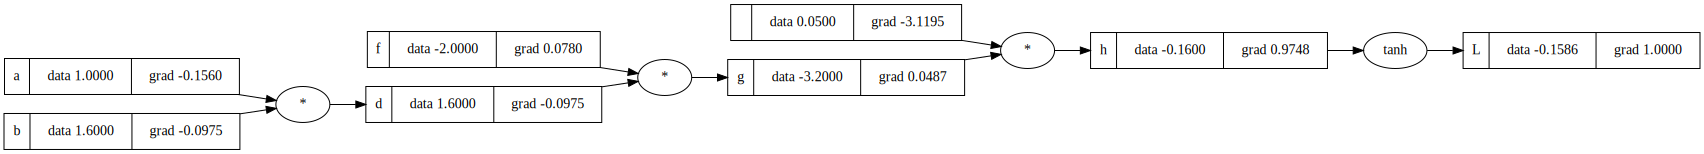

In [42]:
draw_dot(L)

Showing key bug: when one node is used multiple times
it is important to do `self.grad+=...` rather than `self.grad=...`

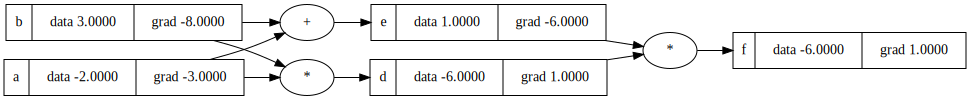

In [43]:
#if you use self.grad= , then the gradients will be overwritten when the child nodes resets the parent node's grad when it is supposed to deposit the grad (accumulate)

a=Value(-2.0, label='a')
b=Value(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'
f.backward()
draw_dot(f)

**some more subtleties of Python**

a*1 will work because `a.__mul__(1)` but 1*a doesnt work because `1.__mul__(a)` access the mul of the float 1

Here's what happens step by step when you try `2.0 * a`:

Python first tries `2.0.__mul__(a)`, which doesn't work because `__mul__` of float doesn't know how to multiply with Value.
Then it tries `a.__rmul__(2.0)`. then it will execute self * other, so access `__mul__` of `a`
If __rmul__ is defined as return other * self, it goes back to step 1, creating an infinite loop.


In [44]:
a=Value(3.0)
print(a+2)

Value(data = 5.0)


### Building neural network library

build neuron

In [45]:
class Neuron:
    def __init__(self, nin):
        #nin is number of inputs to neuron, list of Values
        self.w=[Value(random.uniform(-1,1)) for _ in range (nin)]
        self.b=Value(random.uniform(-1,1))

    def __call__(self,x):
        #when itself is called, must be called with an input x
        #x is a list of the same length as w
        act= sum([w_i*x_i for w_i, x_i in zip(self.w,x)])+self.b
        out=act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
x=[2.0,3.0]
n=Neuron(2)
n(x)

Value(data = 0.4010769707203414)

build layer

In [46]:
class Layer:
    def __init__(self, nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        #list of activations
        outs=[n(x) for n in self.neurons]
        #note that this format means a layer with single neuron will give a Value, not [Value]
        #this is for the final output node
        # this also means your architecture cannot have a single neuron layer in the middle
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        params=[]
        for neuron in self.neurons:
            ps=neuron.parameters()
            '''
            Append adds one element (which can be any object, including another list) to the end of the list.
            Extend adds multiple elements from an iterable to the end of the list.
            If you append a list to another list, it adds the entire list as a single element. 
            If you extend a list with another list, it adds each element of the second list individually.
            '''
            params.extend(ps)
        return params
        #equivalent to return [p for neuron in self.neurons for p in neuron.parameters()]
    
x=[2.0,3.0]
La=Layer(2,3)
La(x)

[Value(data = 0.9879975505950195),
 Value(data = 0.17797657513827),
 Value(data = -0.998067475952897)]

build MLP network

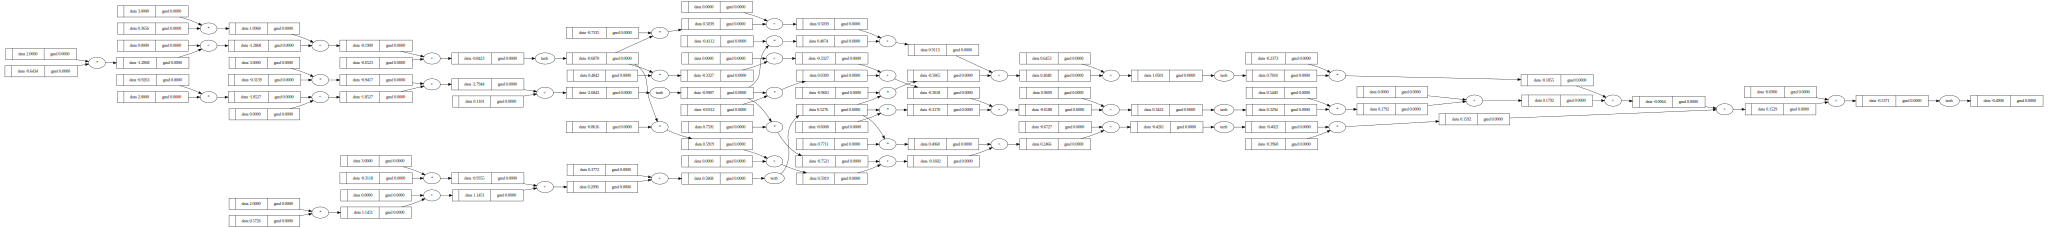

In [47]:
class MLP:
    def __init__(self, nin,nouts):
        '''
        nouts is a list containing the sizes of each layer, after the input layer which is of size nin
        '''
        size=[nin]+nouts
        #first layer is input nin, size[1]
        #size[1] will reference the first elem of nouts because you have concat nin to nouts
        self.layers= [Layer(size[i],size[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x=[2.0,3.0]
NN=MLP(2,[3,3,1])
draw_dot(NN(x))


### Training: creating a tiny dataset,writing loss function, then gradient descent

In [136]:
xs=[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys=[1.0,-1.0,-1.0,1.0] #target data
NN=MLP(3,[4,4,1])


In [150]:
#training
for e in range(100):
    #forward prop, to get activations, loss
    ypred=[NN(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)])

    #grad descent: backprop and update
    '''
    EXTREMELY IMPORTANT to zero grad here! if not the grads from prev epoch will just continue accumulating, and grads jsut get larger and larger
    '''
    #zero all the grads. you can try turning this off, without resetting, to see the effect.
    for p in NN.parameters():
        p.grad=0.0

    #compute gradients
    loss.backward()
    #update params
    for p in NN.parameters():
        p.data += -0.01*p.grad
    
    print(f"epoch{e} and loss{loss}")

print(ypred)

epoch0 and lossValue(data = 0.0019053024322662445)
epoch1 and lossValue(data = 0.0019037447979966511)
epoch2 and lossValue(data = 0.0019021896509791262)
epoch3 and lossValue(data = 0.0019006369853194478)
epoch4 and lossValue(data = 0.001899086795141784)
epoch5 and lossValue(data = 0.001897539074588811)
epoch6 and lossValue(data = 0.0018959938178215426)
epoch7 and lossValue(data = 0.001894451019019275)
epoch8 and lossValue(data = 0.0018929106723795492)
epoch9 and lossValue(data = 0.0018913727721180077)
epoch10 and lossValue(data = 0.001889837312468401)
epoch11 and lossValue(data = 0.0018883042876824982)
epoch12 and lossValue(data = 0.001886773692029949)
epoch13 and lossValue(data = 0.001885245519798345)
epoch14 and lossValue(data = 0.0018837197652930055)
epoch15 and lossValue(data = 0.0018821964228370241)
epoch16 and lossValue(data = 0.0018806754867711241)
epoch17 and lossValue(data = 0.0018791569514536592)
epoch18 and lossValue(data = 0.001877640811260448)
epoch19 and lossValue(data = 

Doing gradient descent